In [23]:
import os
import glob
import numpy as np
import pandas as pd
from obspy import UTCDateTime, read, Stream
import matplotlib.pyplot as plt

project_dir = f'{os.getcwd()}/..'
ppick_dir = f'{project_dir}/results/phasenet_diting_others/phasenet_files'
waveform_dir = f'{project_dir}/data/eq_data/2_waveforms'

allpick_file = f'{ppick_dir}/ALL_PICKS_POL_921.csv'

%reload_ext autoreload
%autoreload 2

In [24]:
# mseed_list = os.listdir(waveform_dir)
# mseed_list = pd.read_csv(f'{ppick_dir}/../mseed_list_47.csv').fname.to_list()
mseed_list = [f for f in os.listdir(waveform_dir) if f.endswith('.mseed')]

In [25]:
# read the ppick file (includes phasenet, diting, pyrocko picks)
pol_df = pd.read_csv(allpick_file, parse_dates=['phase_time'])
print(pol_df.shape[0])
pol_df = pol_df[(pol_df.phase_score>0.95)].sort_values(by=['file_name', 'sta_dist_km', 'phase_score'], ascending=[True, True, False])
print('90% confident: ', pol_df.shape[0])
pol_df.head()

21015
90% confident:  12011


,station_id,begin_time,phase_index,phase_time,phase_score,phase_type,file_name,phase_amplitude,phase_amp,sta_dist_km,diting_polarity,diting_sharpness,pyrocko_phase_time,pyrocko_polarity
0,XQ.ME31.01.BH,2008-04-04 17:10:56.150,3417.0,2008-04-04 17:11:30.245,0.971,P,nc40214567.mseed,16581.435547,16581.435547,5.65,-1,I,NaN,NaN
1,XQ.ME32.01.BH,2008-04-04 17:10:56.150,3462.0,2008-04-04 17:11:30.695,0.981,P,nc40214567.mseed,12086.444336,12086.444336,10.78,-1,I,NaN,NaN
2,BK.JCC..HH,2008-04-04 17:10:56.150,3486.0,2008-04-04 17:11:30.935,0.974,P,nc40214567.mseed,4464.039062,4464.039062,18.23,-1,I,NaN,NaN
4,XQ.ME35.01.BH,2008-04-04 17:10:56.150,3731.0,2008-04-04 17:11:33.385,0.957,P,nc40214567.mseed,6593.771484,6593.771484,25.94,1,E,NaN,NaN
5,XQ.ME34.01.BH,2008-04-04 17:10:56.150,3654.0,2008-04-04 17:11:32.615,0.977,P,nc40214567.mseed,37591.910156,37591.910156,27.30,1,I,NaN,NaN


In [26]:
eq_cat_df = pd.read_csv(f'{project_dir}/data/eq_data/1_eq_catalogs/usgs_eq_above_slab2_all.csv')

# dist_verified_df = pd.DataFrame(columns=pol_df.columns)
# for filename, group_df in pol_df.groupby('file_name'):
#     event_id = filename.split('.')[0]
#     eq_params = eq_cat_df[eq_cat_df.id == event_id].iloc[0]
#     # print(eq_params.mag)
#     if eq_params.mag < 3:
#         cutoff_dist = 150
#     else:
#         cutoff_dist = 175
    
#     group_df = group_df[group_df.sta_dist_km <= cutoff_dist]
#     # concatenate the dfs
#     if group_df.shape[0] > 0:
#         dist_verified_df = pd.concat([dist_verified_df, group_df])
#         dist_verified_df.loc[dist_verified_df.file_name == filename, 'mag'] = eq_params.mag
#         dist_verified_df.loc[dist_verified_df.file_name == filename, 'depth'] = eq_params.depth
#         dist_verified_df.loc[dist_verified_df.file_name == filename, 'lat'] = eq_params.latitude
#         dist_verified_df.loc[dist_verified_df.file_name == filename, 'long'] = eq_params.longitude

# print(dist_verified_df.shape[0])
# dist_verified_df.to_csv(f'{ppick_dir}/ALL_PICKS_POL_921_mag_dist_verified.csv', index=False)

/var/folders/vr/bxyph_y13z17gzq1r_gst6zw0000gn/T/ipykernel_67579/86282962.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dist_verified_df = pd.concat([dist_verified_df, group_df])
/var/folders/vr/bxyph_y13z17gzq1r_gst6zw0000gn/T/ipykernel_67579/86282962.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dist_verified_df = pd.concat([dist_verified_df, group_df])


11585


In [27]:
sel_ev = mseed_list[0]
event_df = dist_verified_df[dist_verified_df["file_name"] == sel_ev]
mag = event_df.mag.iloc[0]
st = read(f"{waveform_dir}/{sel_ev}")
st = st.resample(100)
print(sel_ev, mag)

nc40215740.mseed 2.38


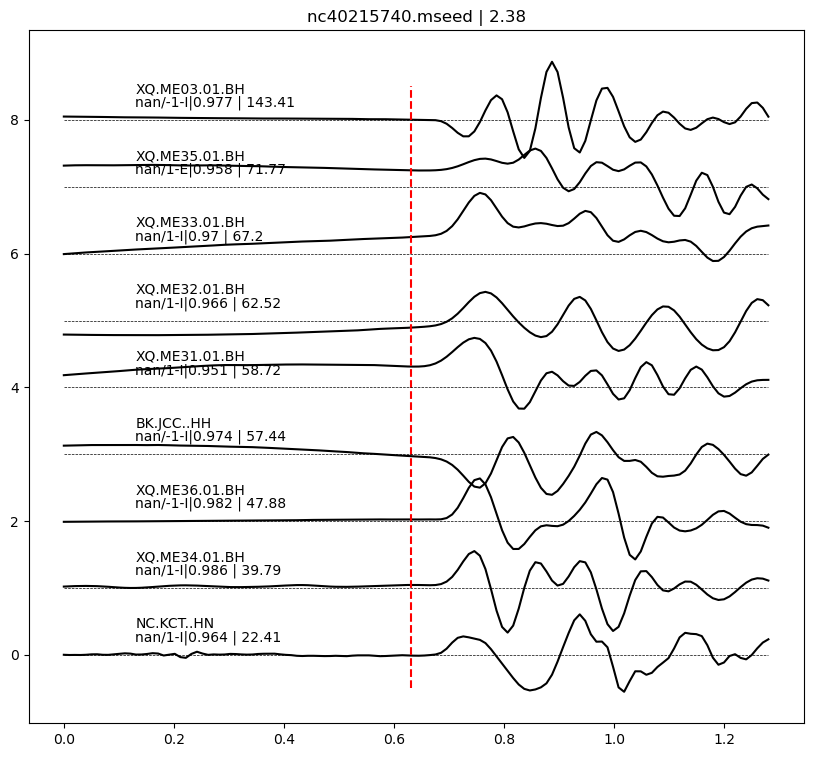

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10, event_df.shape[0]))

iplt = 0
for i, row in event_df.iterrows():
    phase_time = UTCDateTime(pd.to_datetime(str(row.phase_time)))
    ist = st.select(id=f"{row.station_id}Z")

    if len(ist) == 0:
        continue
    tr = ist[0].copy()
    tr.detrend('demean')
    try:
        tr.detrend('linear')
    except:
        tr.detrend('constant')
    
    try:
        tr.taper(0.001)
        tr.filter('bandpass', freqmin=1.5, freqmax=10)
    except:
        pass

    tr = tr.slice(starttime=phase_time-.63, endtime=phase_time+.64)

    pick_sec = np.round(phase_time - tr.stats.starttime, 2) #- 0.1

    # normalize the trace
    tr.data = tr.data / np.max(np.abs(tr.data))

    # varible zoom
    zoom = 2
    spread = np.std(tr.data)          
    vzoom = zoom/np.round(spread, 2)/10 if spread != 0 else zoom

    if len(tr) == 0:
        continue

    xtimes = np.linspace(0, len(tr.data)/tr.stats.sampling_rate, len(tr.data))

    ax.plot(xtimes, tr.data * vzoom + iplt, color='k')
    ax.plot([pick_sec, pick_sec], [iplt - 0.5, iplt+0.5], color='r', linestyle='--')
    ax.text(pick_sec-.5, iplt+.2, f"{row.pyrocko_polarity}/{row.diting_polarity}-{row.diting_sharpness}|{row.phase_score} | {row.sta_dist_km}", color='k')
    ax.text(pick_sec-0.5, iplt+.4, f"{row.station_id}", color='k')
    # horizontal line
    ax.plot([0, len(tr.data)/tr.stats.sampling_rate], [iplt, iplt], color='k', linestyle='--', lw=0.5)
    iplt += 1

    # break

plt.title(f'{sel_ev} | {event_df["mag"].values[0]}')
# flip the y-axis
# plt.gca().invert_yaxis()
plt.show()


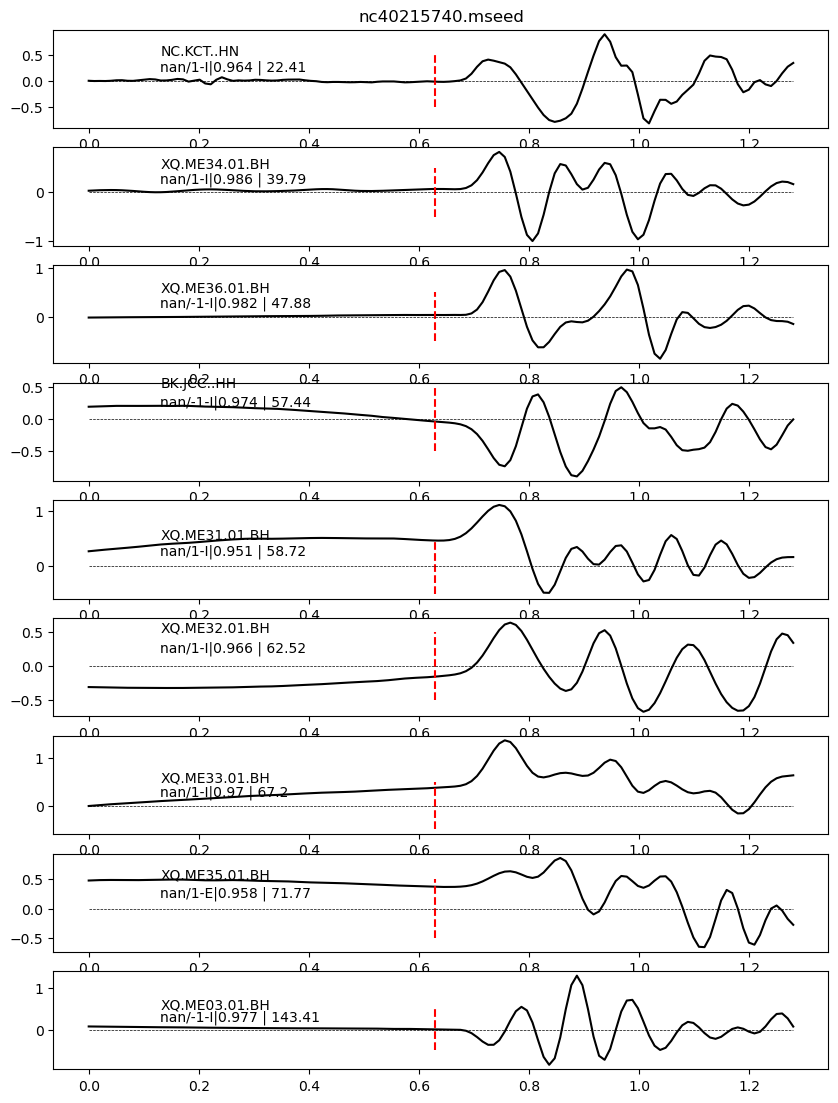

In [29]:
fig, ax = plt.subplots(event_df.shape[0], 1, figsize=(10, 1.5 * event_df.shape[0]))

iplt = 0
for i, row in event_df.iterrows():
    phase_time = UTCDateTime(pd.to_datetime(str(row.phase_time)))
    ist = st.select(id=f"{row.station_id}Z")

    if len(ist) == 0:
        continue
    tr = ist[0].copy()
    tr.detrend('demean')
    try:
        tr.detrend('linear')
    except:
        tr.detrend('constant')
    
    try:
        tr.taper(0.001)
        tr.filter('bandpass', freqmin=1.5, freqmax=10, corners=4, zerophase=True)
    except:
        pass

    tr = tr.slice(starttime=phase_time-.63, endtime=phase_time+.64)

    pick_sec = np.round(phase_time - tr.stats.starttime, 2) #- 0.05

    # normalize the trace
    tr.data = tr.data / np.max(np.abs(tr.data))

    # varible zoom
    zoom = 3
    spread = np.std(tr.data)          
    vzoom = zoom/np.round(spread, 2)/10 if spread != 0 else zoom

    if len(tr) == 0:
        continue

    xtimes = np.linspace(0, len(tr.data)/tr.stats.sampling_rate, len(tr.data))

    ax[iplt].plot(xtimes, tr.data * vzoom, color='k')
    ax[iplt].plot([pick_sec, pick_sec], [-0.5, 0.5], color='r', linestyle='--')  # vertical line
    ax[iplt].text(pick_sec-.5, .2, f"{row.pyrocko_polarity}/{row.diting_polarity}-{row.diting_sharpness}|{row.phase_score} | {row.sta_dist_km}", color='k')
    ax[iplt].text(pick_sec-0.5, .5, f"{row.station_id}", color='k')
    # horizontal line
    ax[iplt].plot([0, len(tr.data)/tr.stats.sampling_rate], [0, 0], color='k', linestyle='--', lw=0.5)

    iplt += 1

    # break

ax[0].set_title(sel_ev)
# plt.tight_layout()
plt.show()
